In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from conformal_prediction import CP, calc_coverage
from preprocess_data import recode_variables_NHANES, split_train_cal_test
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler

ImportError: cannot import name 'recode_variables' from 'preprocess_data' (/Users/carlharris/PycharmProjects/conformal_prediction_NHANES/preprocess_data.py)

In [3]:
plots_folder = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/plots'
results_folder = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/results'

In [4]:
f_path = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/data.csv'
df = pd.read_csv(f_path, na_values="None")
df = df.replace(to_replace=' ', value=np.nan)
df['Education'] = df['Education'].astype(float)
df = recode_variables(df)

In [5]:
# df.drop(df[df['Female'] == 1].index, inplace=True)
df.dropna(inplace=True)

ed_dummies = ['Ed_less_9th', 'Ed_9th_11th', 'Ed_HS_GED', 'Ed_some_coll_AA', 'Ed_coll_above', 'Ed_refused', 'Ed_dk']
eth_dummies = ['Eth_Mex_Am', 'Eth_Oth_Hisp', 'Eth_Nonhisp_White', 'Eth_Nonhisp_Black', 'Eth_Other']

X = df[[ 'Age', 'Female',  'Weight', 'Height'] + ed_dummies + eth_dummies]

outcome = 'Waist'
y = df[[outcome]]
y = y[outcome].astype(float)

In [7]:
# scaler = StandardScaler()
# scaler.fit(X)
# X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

In [9]:
from sklearn.linear_model import LinearRegression

X_train, X_cal, X_test, y_train, y_cal, y_test = split_train_cal_test(X, y, trn_prop=0.5, cal_prop=0.25)

alpha = 0.05
reg = CP(X_train, X_cal, y_train, y_cal, alpha=alpha, regressor="QR")
# reg.hyperparam_search(n_iter=10)
reg.train()

Fitting lower quantile (0.025)
Fitting median quantile (0.5)
Fitting upper quantile (0.975)


In [10]:
reg.calc_qhat()
cp_pred_df = reg.predict_cp_quantiles(X_test, y_test)

Calculating scores
At alpha=0.05, qhat = 0.13391418997490234
Conformalizing with qhat=0.13391418997490234


Predicted CIs (sorted by y_true)

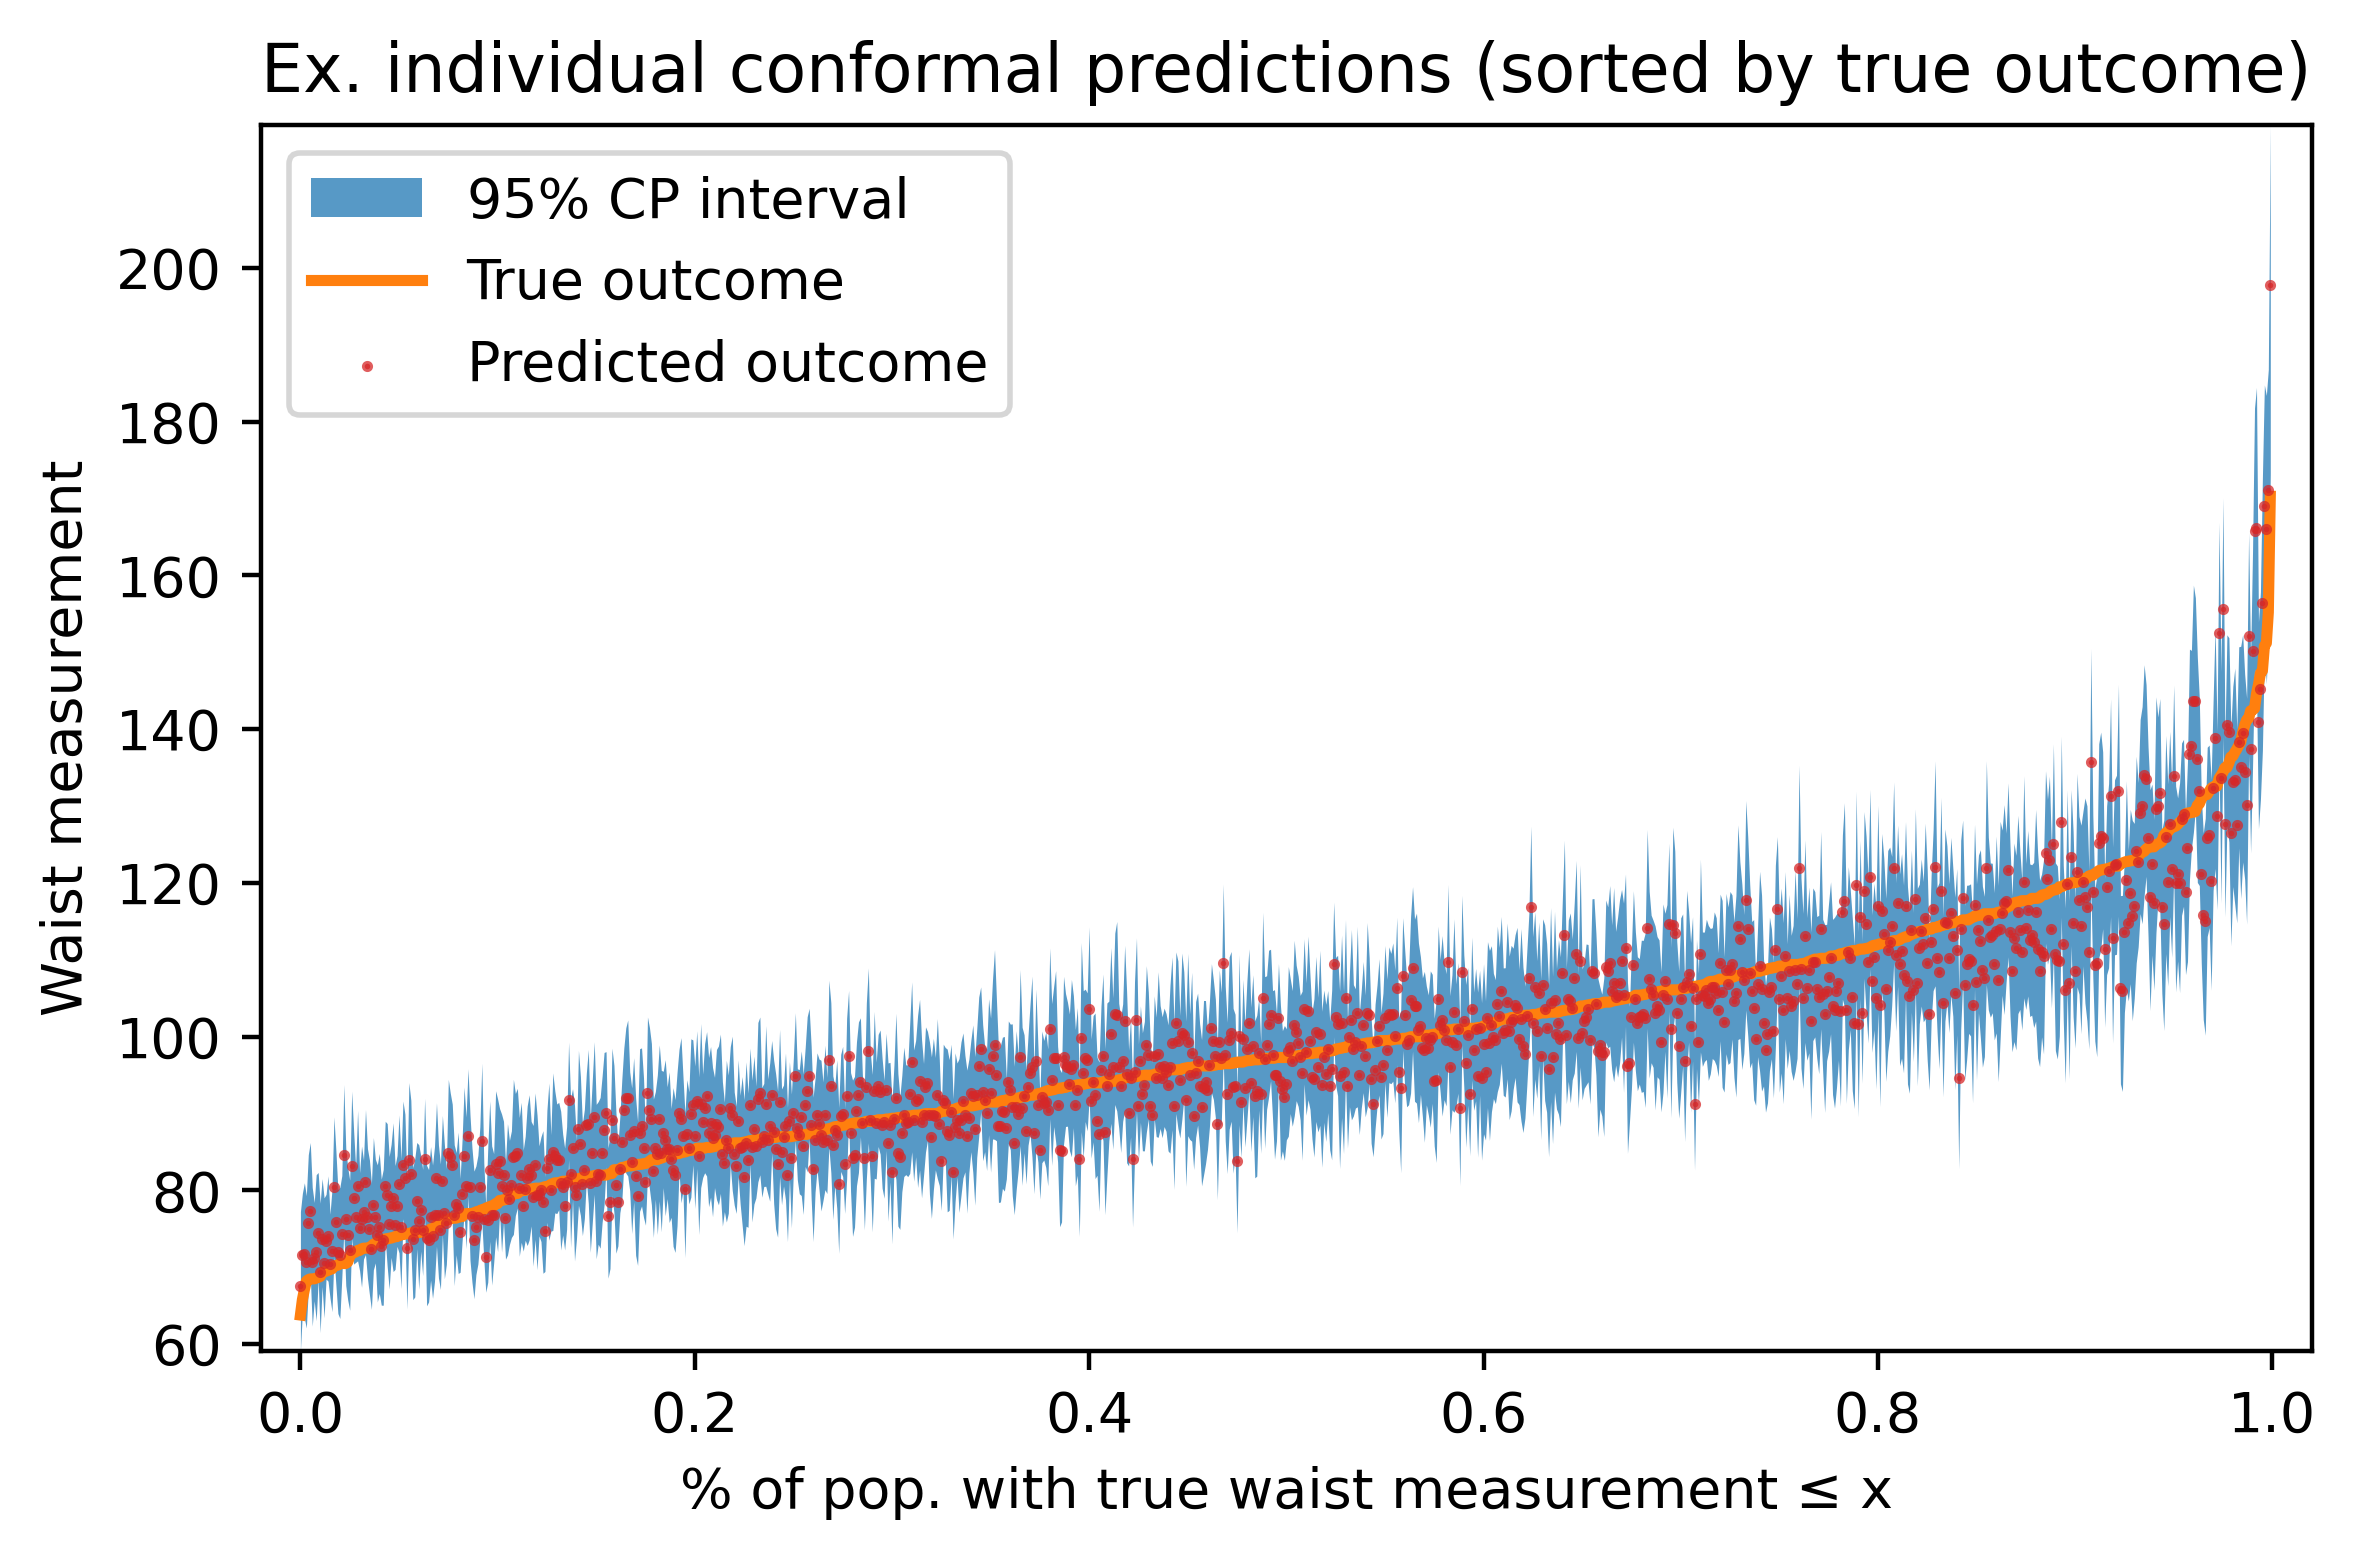

In [11]:
sample_df = cp_pred_df.copy()
n_sample = 1000

sample_df = sample_df.sample(n = n_sample)
sample_df = sample_df.sort_values(by=['y_true'])
sample_df = sample_df.reset_index()

plt.figure(figsize=(6, 4), dpi=400)

lbl = "{:.0f}% CP interval".format((1-alpha) * 100)
plt.fill_between(sample_df.index/n_sample, sample_df['lower'], sample_df['upper'], alpha=0.75, color='C0', label=lbl, linewidth=0, zorder=1)
plt.plot(sample_df.index/n_sample, sample_df['y_true'], linewidth=2, color='C1', label="True outcome", zorder=2)
plt.scatter(sample_df.index/n_sample, sample_df['median'], s=1, color='C3', label="Predicted outcome", alpha=0.75, zorder=3)

plt.title("Ex. individual conformal predictions (sorted by true outcome)")
plt.legend(loc='upper left')
plt.ylabel(f"{outcome} measurement")
plt.xlabel(f"% of pop. with true {outcome.lower()} measurement ≤ x")
plt.xlim([-0.02, 1.02])
plt.ylim([np.min(sample_df['lower']), np.max(sample_df['upper'])])
plt.tight_layout()
img_path = os.path.join(plots_folder, "ex_preds_by_true_y_{:.0f}Q.pdf".format((1-alpha) * 100))
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

Predicted CIs (sorted by y_median)

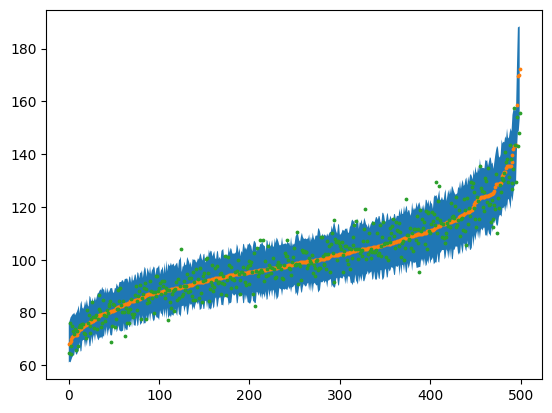

In [12]:
sample_df = cp_pred_df.copy()
sample_df = sample_df.sample(n = 500)
sample_df = sample_df.sort_values(by=['median'])
sample_df = sample_df.reset_index()

plt.fill_between(sample_df.index, sample_df['lower'], sample_df['upper'])
plt.scatter(sample_df.index, sample_df['median'], s=3)
plt.scatter(sample_df.index, sample_df['y_true'], s=3)

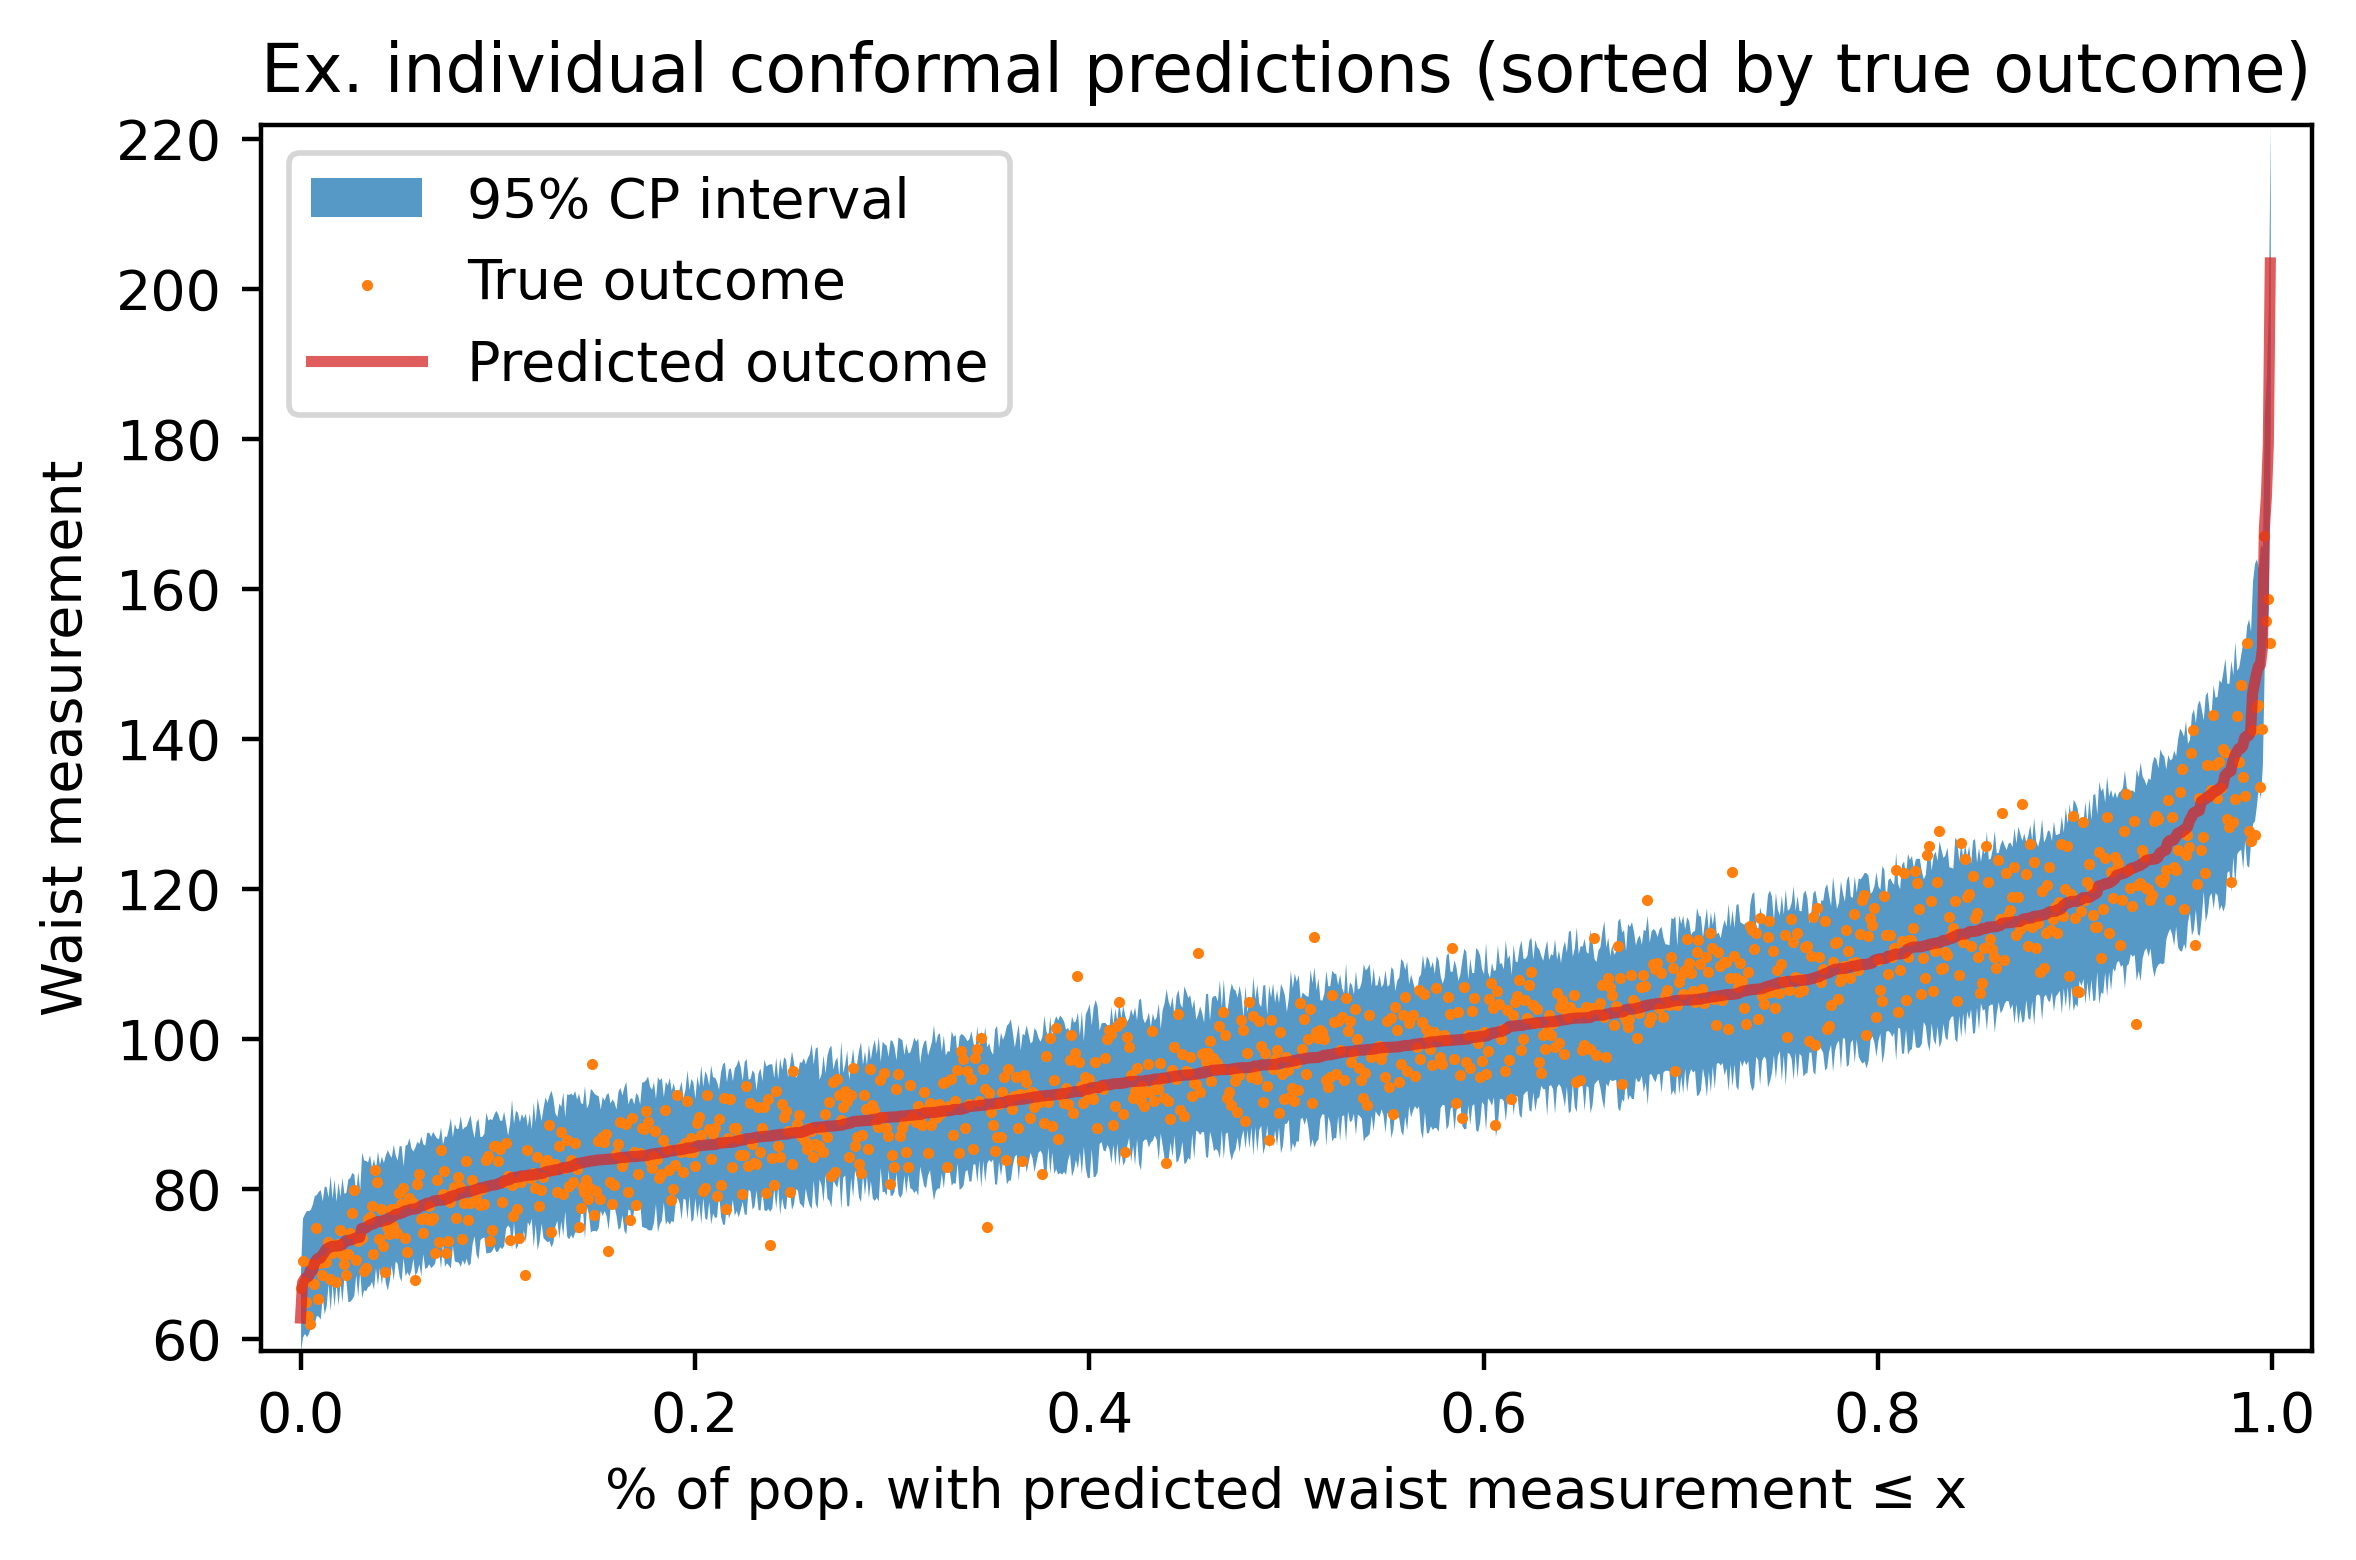

In [13]:
sample_df = cp_pred_df.copy()
n_sample = 1000

sample_df = sample_df.sample(n = n_sample)
sample_df = sample_df.sort_values(by=['median'])
sample_df = sample_df.reset_index()

plt.figure(figsize=(6, 4), dpi=400)

lbl = "{:.0f}% CP interval".format((1-alpha) * 100)
plt.fill_between(sample_df.index/n_sample, sample_df['lower'], sample_df['upper'], alpha=0.75, color='C0', label=lbl, linewidth=0, zorder=1)
plt.scatter(sample_df.index/n_sample, sample_df['y_true'], s=1, color='C1', label="True outcome", zorder=2)
plt.plot(sample_df.index/n_sample, sample_df['median'], linewidth=2, color='C3', label="Predicted outcome", alpha=0.75, zorder=3)

plt.title("Ex. individual conformal predictions (sorted by true outcome)")
plt.legend(loc='upper left')
plt.ylabel(f"{outcome} measurement")
plt.xlabel(f"% of pop. with predicted {outcome.lower()} measurement ≤ x")
plt.xlim([-0.02, 1.02])
plt.ylim([np.min(sample_df['lower']), np.max(sample_df['upper'])])
plt.tight_layout()
img_path = os.path.join(plots_folder, "ex_preds_by_pred_y_{:.0f}Q.pdf".format((1-alpha) * 100))
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

Coverage by difference size

/Users/carlharris/miniconda3/envs/CP_waist_circumference/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Range 9.968828596549315 to 16.29242672083444: 0.9345454545454546
Range 16.293086439957875 to 18.438622573189832: 0.9568831168831169
Range 18.4412631488744 to 20.528690685246602: 0.9693506493506493
Range 20.531315489688623 to 23.292467066688516: 0.9594805194805195
Range 23.29378100621841 to 45.39775388915848: 0.9454261954261954


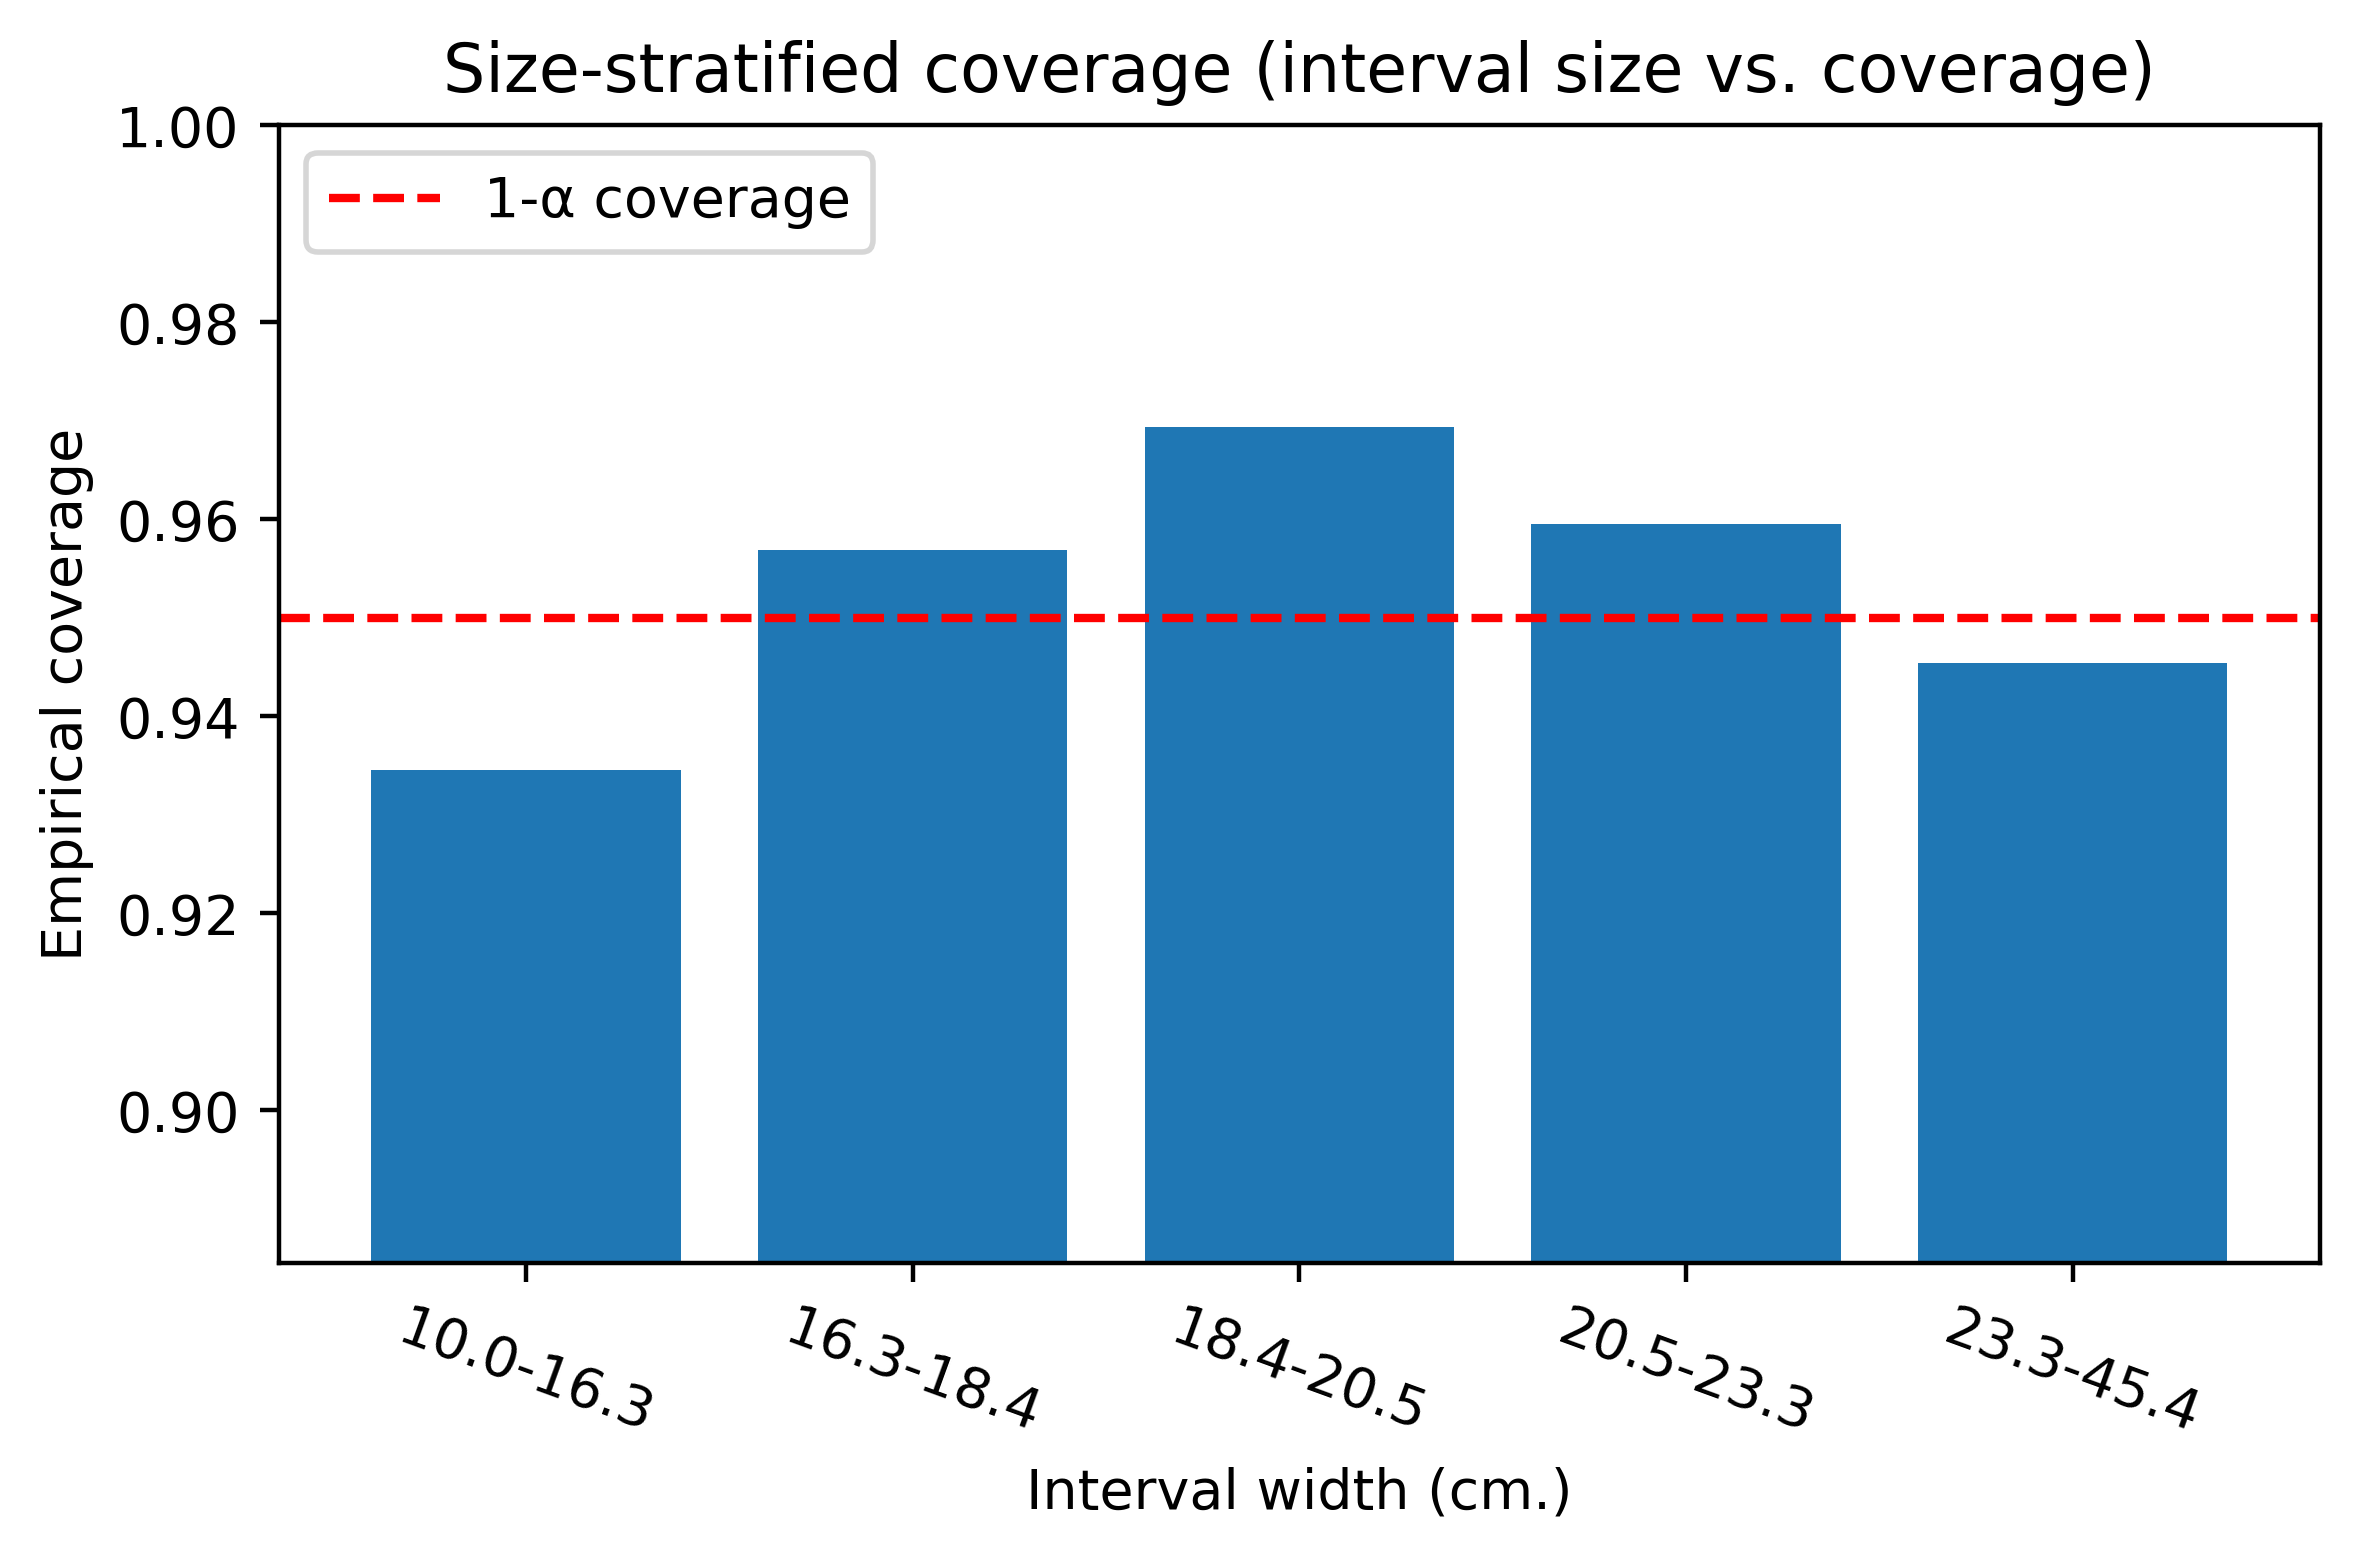

In [14]:
test_cp_df_tmp = cp_pred_df.copy()
test_cp_df_tmp = test_cp_df_tmp.sort_values(by=["diff"])
test_cp_df_tmp = test_cp_df_tmp.reset_index()
dfs = np.array_split(test_cp_df_tmp, 5)

plt.figure(figsize=(6, 4), dpi=400)
x_labels = []
coverages = []
for i, split_df in enumerate(dfs):
    min_max = (split_df['diff'].iloc[0], split_df['diff'].iloc[-1])
    coverage = calc_coverage(split_df)
    print(f"Range {min_max[0]} to {min_max[1]}: {coverage}")
    coverages.append(coverage)
    
    x_labels.append("{:.1f}-{:.1f}".format(min_max[0], min_max[1]))

plt.bar(np.arange(len(coverages)), coverages)
if np.max(coverages)+0.05 < 1:
    bar_max = np.max(coverages)+0.05
else:
    bar_max = 1
plt.ylim(np.min(coverages)-0.05, bar_max)
plt.axhline(y=1-alpha, color='r', linestyle='--', label="1-α coverage")
plt.xticks(np.arange(len(coverages)), x_labels, rotation=-20)

plt.title("Size-stratified coverage (interval size vs. coverage)")
plt.ylabel('Empirical coverage')
plt.legend(loc='upper left')
plt.xlabel("Interval width (cm.)")
plt.tight_layout()
img_path = os.path.join(plots_folder, "SSC_{:.0f}Q.pdf".format((1-alpha) * 100))
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

Coverage by true WC

In [ ]:
test_cp_df_tmp = cp_pred_df.copy()
test_cp_df_tmp = test_cp_df_tmp.sort_values(by=["y_true"])
test_cp_df_tmp = test_cp_df_tmp.reset_index()
dfs = np.array_split(test_cp_df_tmp, 5)

plt.figure(figsize=(6, 4), dpi=400)
x_labels = []
coverages = []
for split_df in dfs:
    min_max = (split_df['y_true'].iloc[0], split_df['y_true'].iloc[-1])
    coverage = calc_coverage(split_df)
    print(f"Range {min_max[0]} to {min_max[1]}: {coverage} (avg diff = {np.mean(split_df['diff'])})")
    coverages.append(coverage)
    
    x_labels.append("{:.1f}-{:.1f}".format(min_max[0], min_max[1]))
    
plt.bar(np.arange(len(coverages)), coverages)
if np.max(coverages)+0.05 < 1:
    bar_max = np.max(coverages)+0.05
else:
    bar_max = 1
plt.ylim(np.min(coverages)-0.05, bar_max)
plt.axhline(y=1-alpha, color='r', linestyle='--', label="1-α coverage")
plt.xticks(np.arange(len(coverages)), x_labels, rotation=-45)
plt.title("Outcome-conditional coverage (true outcome vs. coverage)")
plt.ylabel('Empirical coverage')
plt.legend(loc='upper left')
plt.xlabel(f"True {outcome} measurement (cm.)")
plt.tight_layout()
img_path = os.path.join(plots_folder, "OCC_{:.0f}Q.pdf".format((1-alpha) * 100))
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

Coverage by ethnicity

In [ ]:
plt.figure(figsize=(6, 4), dpi=400)
x_labels = []
coverages = []

for col in eth_dummies:
    y_col = cp_pred_df[X_test[col] == 1]
    coverage = calc_coverage(y_col)
    print(f"{col}: {coverage}")
    coverages.append(coverage)
    x_labels.append(col)

plt.bar(np.arange(len(coverages)), coverages)
if np.max(coverages)+0.05 < 1:
    bar_max = np.max(coverages)+0.05
else:
    bar_max = 1
plt.ylim(np.min(coverages)-0.05, bar_max)
plt.axhline(y=1-alpha, color='r', linestyle='--', label="1-α coverage")
plt.xticks(np.arange(len(coverages)), x_labels, rotation=-45)
plt.title("Feature-stratified coverage: Ethnicity")
plt.ylabel('Empirical coverage')
plt.legend(loc='upper left')
plt.xlabel(f"Race/ethnicity")
plt.tight_layout()
img_path = os.path.join(plots_folder, "FSC_ethnicity_{:.0f}Q.pdf".format((1-alpha) * 100))
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

Coverage by education

In [ ]:
plt.figure(figsize=(6, 4), dpi=400)

x_labels = []
coverages = []

for col in ed_dummies:
    y_col = cp_pred_df[X_test[col] == 1]
    coverage = calc_coverage(y_col)
    print(f"{col}: {coverage}")
    coverages.append(coverage)
    x_labels.append(col)

plt.bar(np.arange(len(coverages)), coverages)
if np.max(coverages)+0.05 < 1:
    bar_max = np.max(coverages)+0.05
else:
    bar_max = 1
plt.ylim(1-2*alpha, bar_max)
plt.axhline(y=1-alpha, color='r', linestyle='--', label="1-α coverage")
plt.xticks(np.arange(len(coverages)), x_labels, rotation=-45)
plt.title("Feature-stratified coverage: Education")
plt.ylabel('Empirical coverage')
plt.legend(loc='upper left')
plt.xlabel(f"Education level")
plt.tight_layout()
img_path = os.path.join(plots_folder, "FSC_education_{:.0f}Q.pdf".format((1-alpha) * 100))
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

In [15]:
from sklearn.metrics import r2_score
from sklearn.metrics import d2_pinball_score

r2 = r2_score(cp_pred_df['y_true'], cp_pred_df['lower'])
print(f"R2: {r2}")

r2 = r2_score(cp_pred_df['y_true'], cp_pred_df['upper'])
print(f"R2: {r2}")

r2 = r2_score(cp_pred_df['y_true'], cp_pred_df['median'])
print(f"R2: {r2}")

R2: 0.5181530979064779
R2: 0.5261295752262363
R2: 0.9022713741537334


Prediction interval size

19.939184631518096


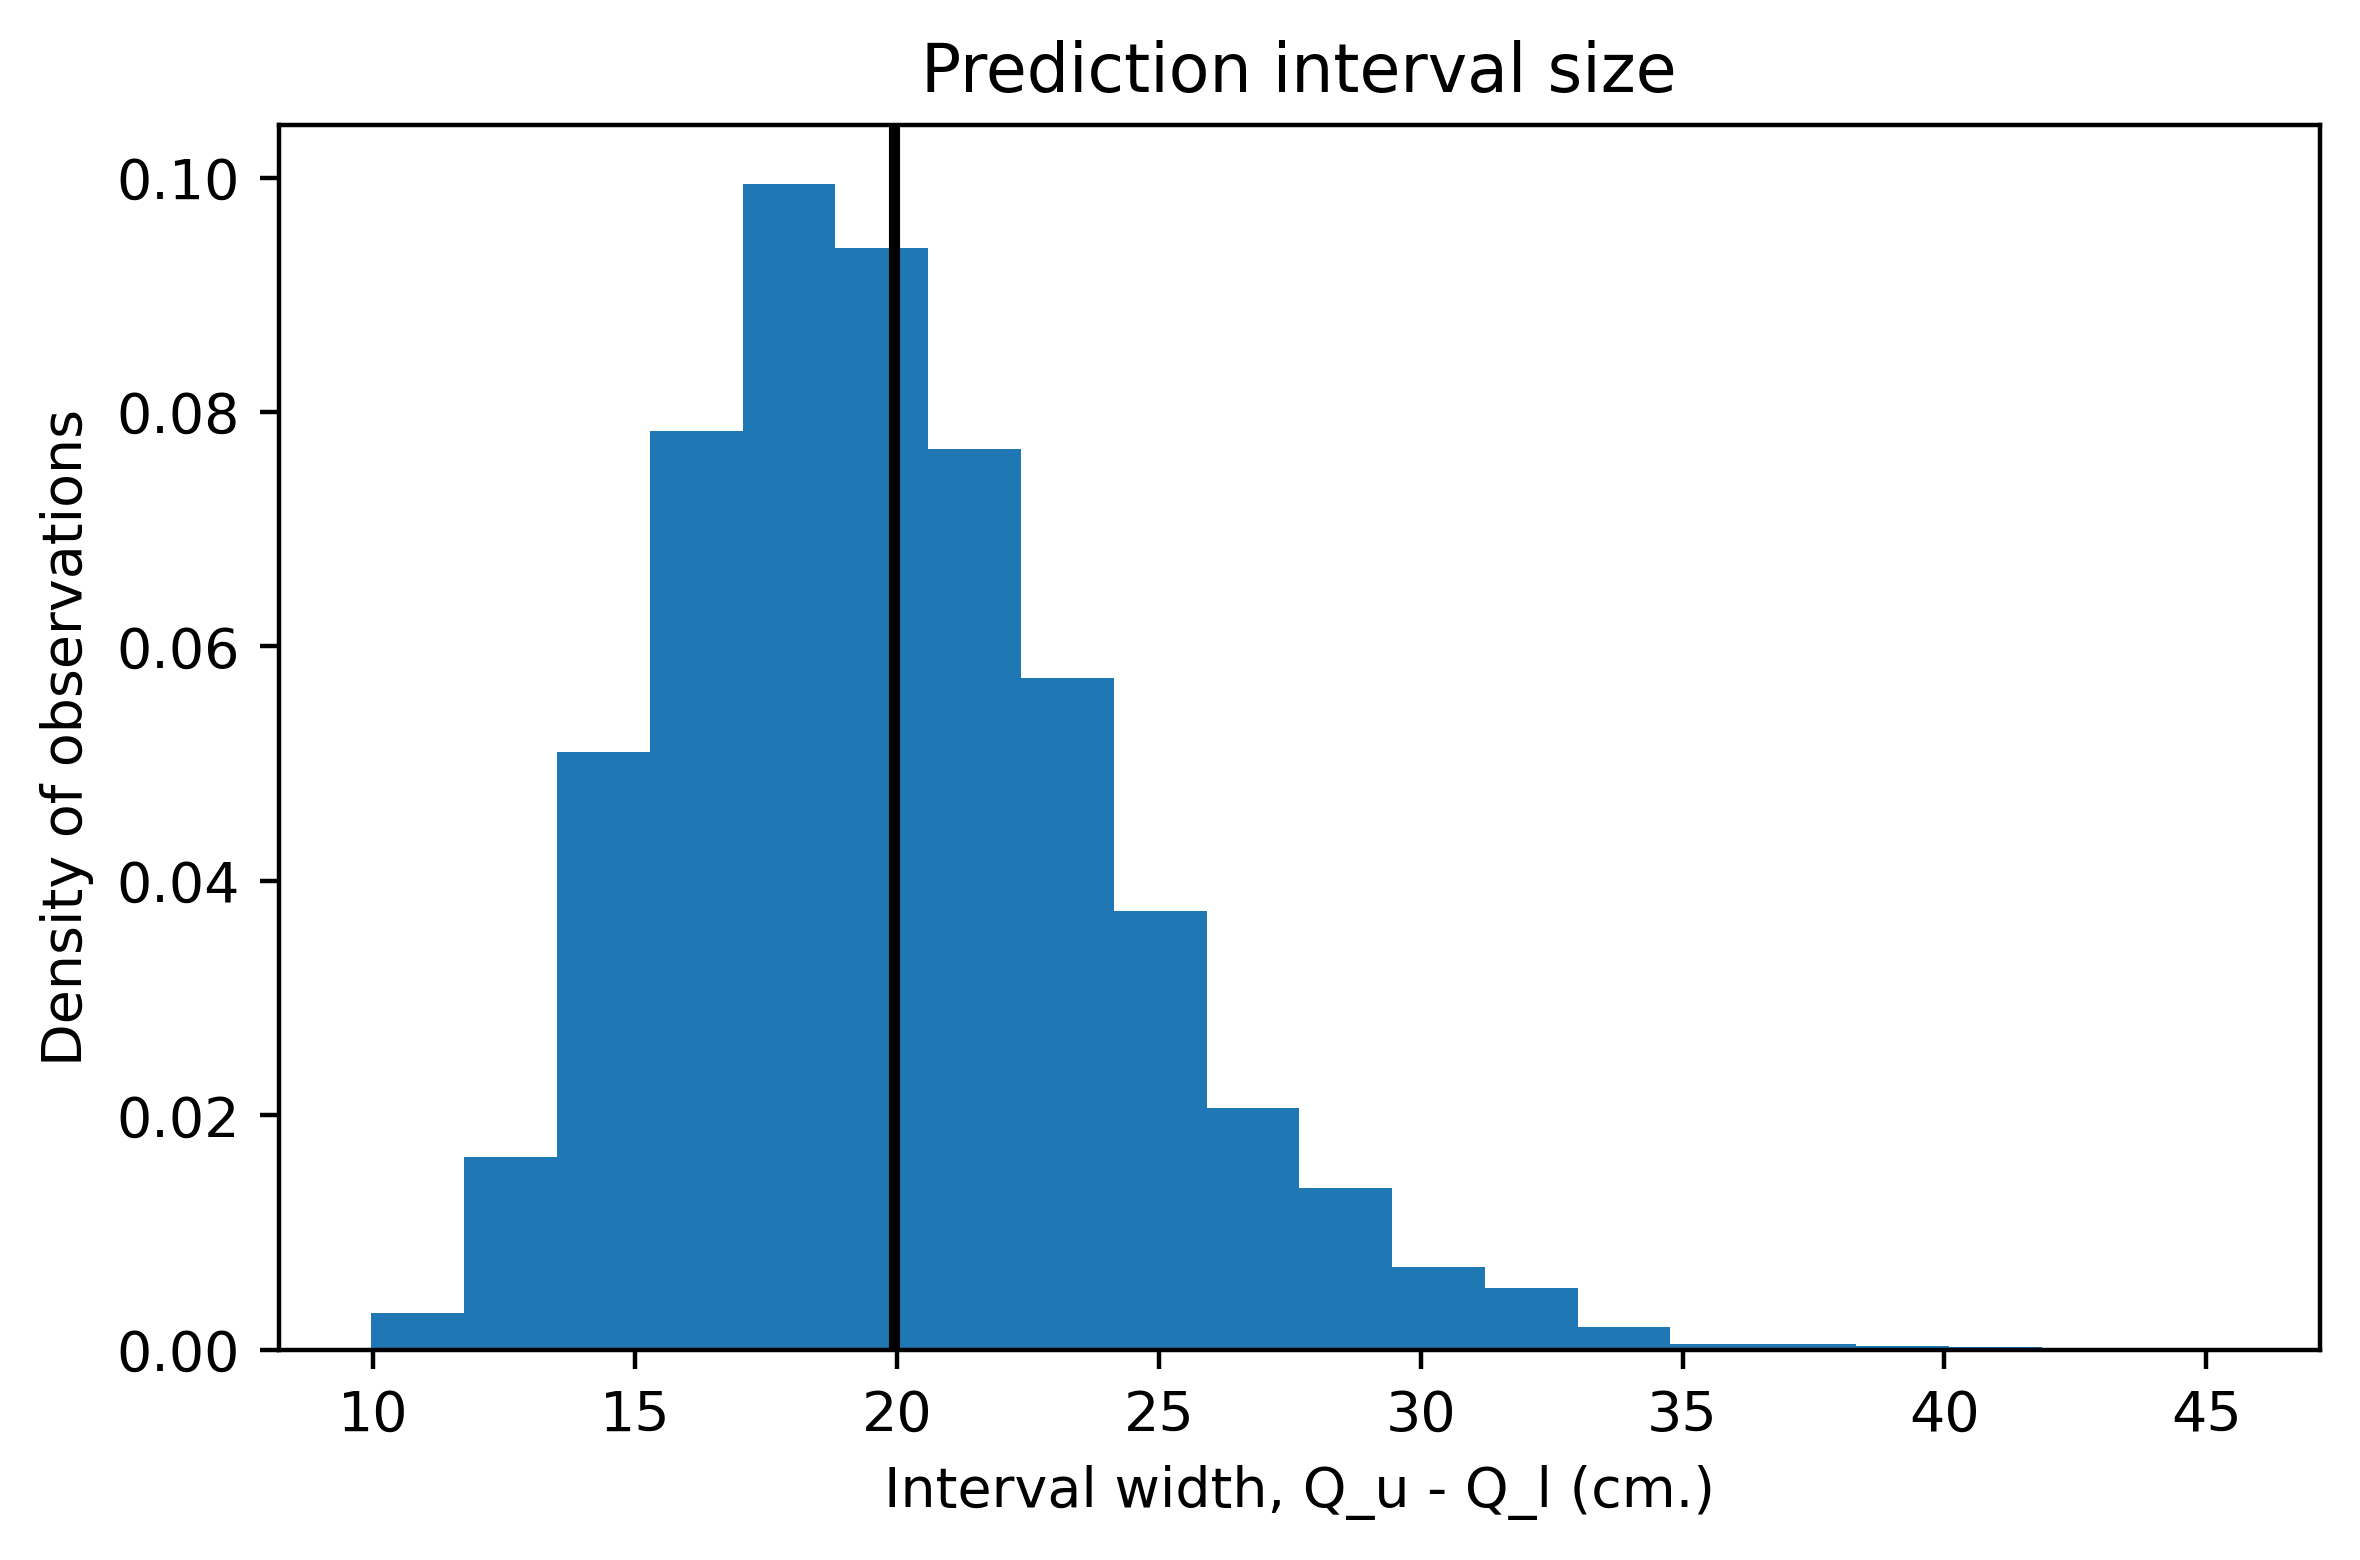

In [16]:
plt.figure(figsize=(6, 4), dpi=400)

plt.hist(cp_pred_df['diff'], bins=20, density=True)
print(np.mean(cp_pred_df['diff']))
plt.title("Prediction interval size")
plt.xlabel("Interval width, Q_u - Q_l (cm.)")
plt.ylabel('Density of observations')
plt.tight_layout()
plt.axvline(x=np.mean(cp_pred_df['diff']), color='black', linewidth=2)
img_path = os.path.join(plots_folder, "cp_interval_size_{:.0f}Q.pdf".format((1-alpha) * 100))
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
lr = LinearRegression().fit(X_train, y_train)
y_hat = lr.predict(X_test)
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_hat)
print(f"R2: {r2}")

Interval size over alpha

In [ ]:
n_inner_loops = 3
alphas = [0.2, 0.1, 0.05, 0.01]
cp_dfs = []
for alpha in  alphas:
    cp_pred_df = pd.DataFrame()
    for i in range(n_inner_loops):
        X_train, X_cal, X_test, y_train, y_cal, y_test = split_train_cal_test(X, y, trn_prop=0.5, cal_prop=0.25)
        reg = CP(X_train, X_cal, y_train, y_cal, alpha=alpha, regressor="QR")
        # reg.hyperparam_search(n_iter=10)
        reg.train()
        reg.calc_qhat()
        tmp_cp_pred_df = reg.predict_cp_quantiles(X_test, y_test)
        cp_pred_df = pd.concat([cp_pred_df, tmp_cp_pred_df], axis=0)
    cp_dfs.append(cp_pred_df)

In [ ]:


colors = ['C0', 'C1', 'C2', 'C3']
for i, cp_df in enumerate(cp_dfs):
    plt.hist(cp_df['diff'], bins=25, color=colors[i], alpha=0.7-0.1*i, label="α={:.2f}".format(alphas[i]), density=True)
    plt.axvline(x=np.mean(cp_df['diff']), color=colors[i], linewidth=2)
plt.ylim([0, 0.2])
plt.xlim([5, 55])
plt.ylabel('Density of observations')
plt.xlabel("Interval width, Q_u - Q_l (cm.)")
plt.title("Specified α vs. interval size")
plt.legend()
plt.tight_layout()
img_path = os.path.join(plots_folder, "alpha_vs_interval_size.pdf".format((1-alpha) * 100))
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()
